# importing libraries....

In [1]:
import pandas  as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from collections import Counter
import re
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding
import warnings
import random
import os
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from tensorflow.keras import layers
from keras.utils import to_categorical

In [2]:
# check for GPU...
print(f"TensorFlow has access to following devices : ")
for device in tf.config.list_physical_devices():
    print(f". {device}")

TensorFlow has access to following devices : 
. PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
. PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
# filter warnings...
warnings.filterwarnings("ignore")

# EDA

In [4]:
# getting the data
train = pd.read_csv("tweet-sentiment-extraction/train.csv")
test = pd.read_csv("tweet-sentiment-extraction/test.csv")
sub = pd.read_csv("tweet-sentiment-extraction/sample_submission.csv")
# train data head....
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [5]:
# test data head....
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [6]:
# submissive data...
sub.head()

,textID,selected_text
0,f87dea47db,NaN
1,96d74cb729,NaN
2,eee518ae67,NaN
3,01082688c6,NaN
4,33987a8ee5,NaN


In [7]:
# train data shape
train.shape

(27481, 4)

In [8]:
# data info....
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [9]:
# looking for null values...
train.isna().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [10]:
# as there is onyl single null value in training set, so it's better to drop it...
train.dropna(inplace=True)

In [11]:
# looking for null value in test set..
test.isna().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [12]:
# target label distribution....
sentiment = train["sentiment"].value_counts()
sentiment

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [13]:
# setting the plot style...
plt.style.use("ggplot")

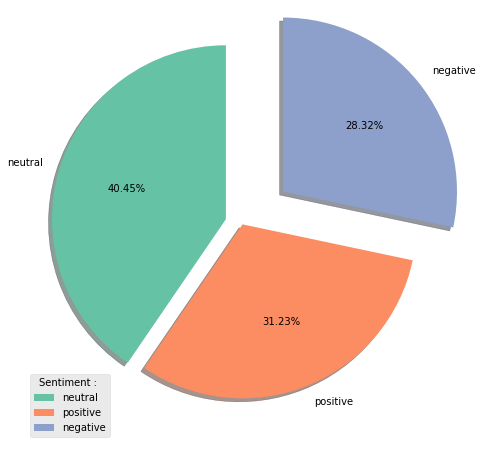

In [14]:
# plot the sentiment distribution...
plt.figure(figsize=(10,8))
labels = sentiment.index
colors = sns.color_palette("Set2")
explode = [0.1,0,0.3]
plt.pie(sentiment,labels = labels, colors = colors, explode = explode,
       autopct = "%.2f%%", startangle = 90, shadow = True)
plt.legend(title = "Sentiment : ")
plt.show()

In [15]:
# test data target label distribution
test_sentiment = test.sentiment.value_counts()
test_sentiment

neutral     1430
positive    1103
negative    1001
Name: sentiment, dtype: int64

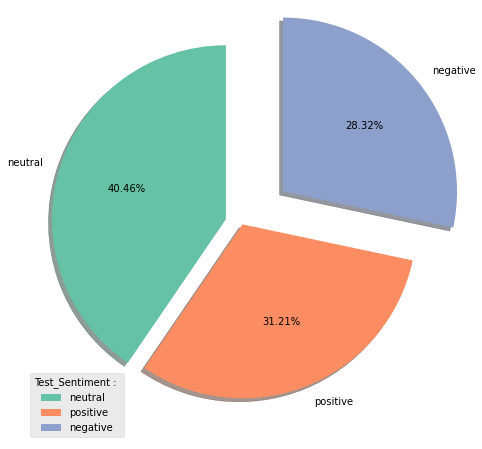

In [16]:
# plot the sentiment distribution...
plt.figure(figsize=(10,8))
labels = test_sentiment.index
colors = sns.color_palette("Set2")
explode = [0.1,0,0.3]
plt.pie(test_sentiment,labels = labels, colors = colors, explode = explode,
       autopct = "%.2f%%", startangle = 90, shadow = True)
plt.legend(title = "Test_Sentiment : ")
plt.show()

In [17]:
# changing the data-type...
train["text"] =  train["text"].astype("string")

In [18]:
# checking the length of the selected text...
train["length"] = train["text"].apply(lambda x: len(x.split()))
train.head()

,textID,text,selected_text,sentiment,length
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14


In [19]:
# checking the length of test text data
test["length"] = test["text"].apply(lambda x: len(x.split()))
test

,textID,text,sentiment,length
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral,6
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive,15
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative,13
3,01082688c6,happy bday!,positive,2
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive,5
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",negative,15
3530,416863ce47,All alone in this old house again. Thanks for...,positive,26
3531,6332da480c,I know what you mean. My little dog is sinkin...,negative,18
3532,df1baec676,_sutra what is your next youtube video gonna b...,positive,14


In [20]:
print(f"Max length of tweet text in training set : {train['length'].max()}")
print(f"Min lenght of tweet text in training set. : {train['length'].min()}")
print(f"Max length of tweet text in test set : {test['length'].max()}")
print(f"Min lenght of tweet text in test set. : {test['length'].min()}")

Max length of tweet text in training set : 33
Min lenght of tweet text in training set. : 1
Max length of tweet text in test set : 32
Min lenght of tweet text in test set. : 1


In [21]:
print(f"Shortest tweets in training set : \n{train[train['length']==min(train['length'])]}")

Shortest tweets in training set : 
           textID           text selected_text sentiment  length
42     2e7082d1c8       MAYDAY?!      MAYDAY?!   neutral       1
68     fa2654e730       Chilliin      Chilliin  positive       1
127    8e1583cb08     Absolutely    Absolutely   neutral       1
224    f3a77c2b5e       _nesmith      _nesmith   neutral       1
238    e98226e842            Thx           Thx   neutral       1
...           ...            ...           ...       ...     ...
26690  e80c242d6a     Goodnight;    Goodnight;  positive       1
26693  7dc13f50d8   yessssssir!!  yessssssir!!   neutral       1
26726  aad244f37d          *hug*         *hug*  positive       1
26754  b6f6bd82c0       careless      careless  negative       1
26843  a46571fe12      congrats!     congrats!  positive       1

[199 rows x 5 columns]


In [22]:
print(f"longest tweets in training set : \n{train[train['length']==max(train['length'])]}")

longest tweets in training set : 
           textID                                               text  \
19887  ede80b9f63  AK, flop comes 2K6 I bet 15 get raised to 25 I...   
25359  be445111e7  : Lol it went okay! As far as I can tell . But...   

                                           selected_text sentiment  length  
19887  AK, flop comes 2K6 I bet 15 get raised to 25 I...   neutral      33  
25359                               Lol it went okay! As  positive      33  


<Figure size 720x576 with 0 Axes>

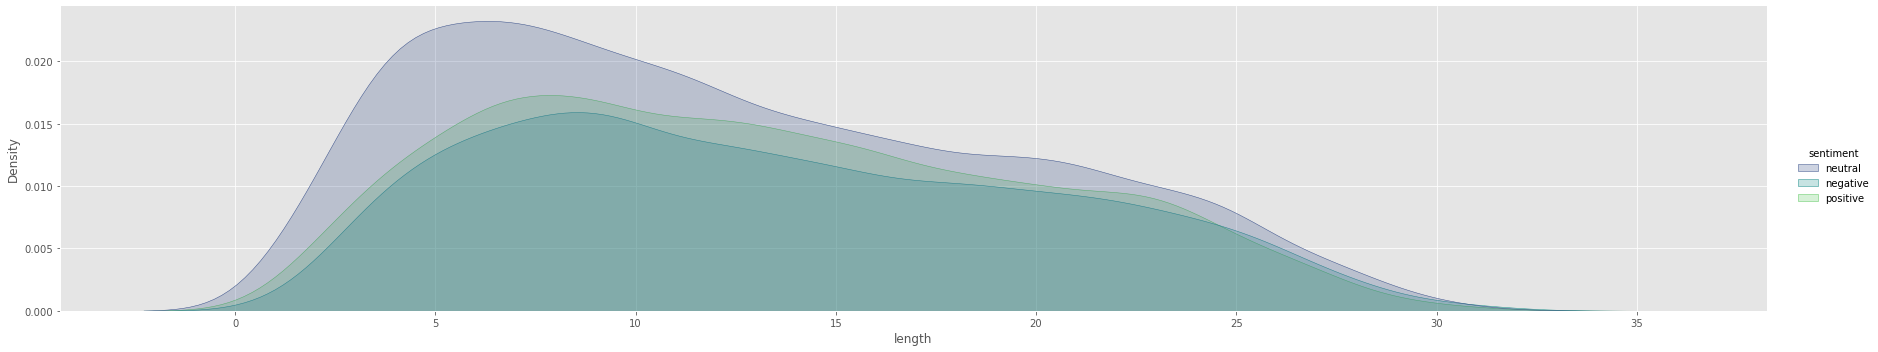

In [23]:
# plot the length of tweet text across the sentiment....
plt.figure(figsize=(10,8))
sns.displot(data = train, x = "length", hue = "sentiment",
           kind = "kde", fill = True, aspect = 5, palette = "viridis");

<Figure size 720x576 with 0 Axes>

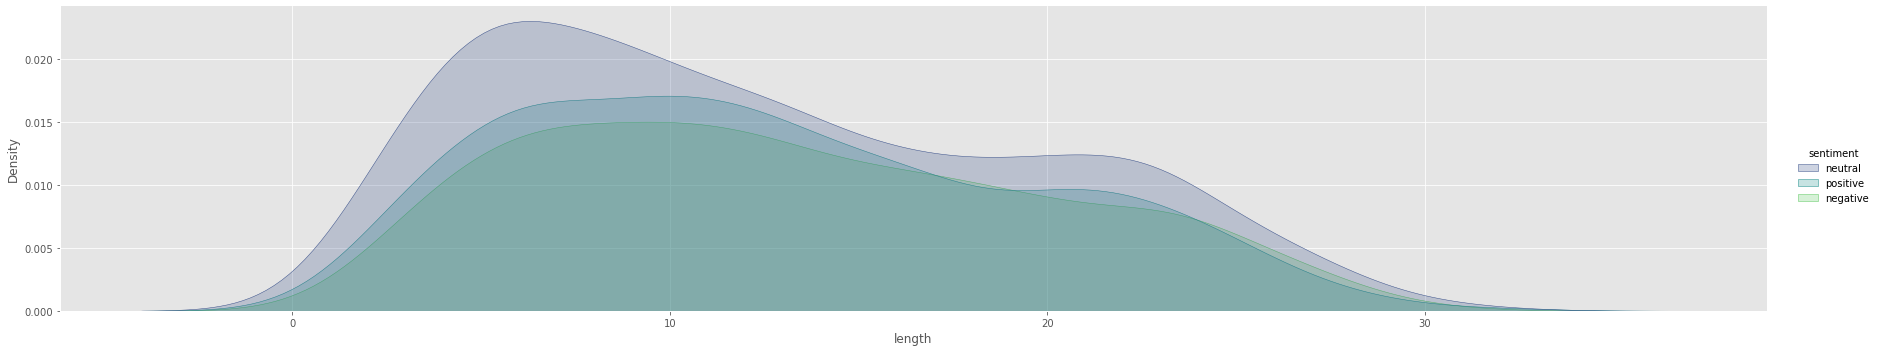

In [24]:
# plot the length of test tweet text across the sentiment....
plt.figure(figsize=(10,8))
sns.displot(data = test, x = "length", hue = "sentiment",
           kind = "kde", fill = True, aspect = 5, palette = "viridis");

In [25]:
# let's drop the selected_text column 
train.drop("selected_text",axis=1,inplace=True)

In [26]:
train.head(10)

,textID,text,sentiment,length
0,cb774db0d1,"I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,negative,10
2,088c60f138,my boss is bullying me...,negative,5
3,9642c003ef,what interview! leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...",negative,14
5,28b57f3990,http://www.dothebouncy.com/smf - some shameles...,neutral,12
6,6e0c6d75b1,2am feedings for the baby are fun when he is a...,positive,14
7,50e14c0bb8,Soooo high,neutral,2
8,e050245fbd,Both of you,neutral,3
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe....,positive,10


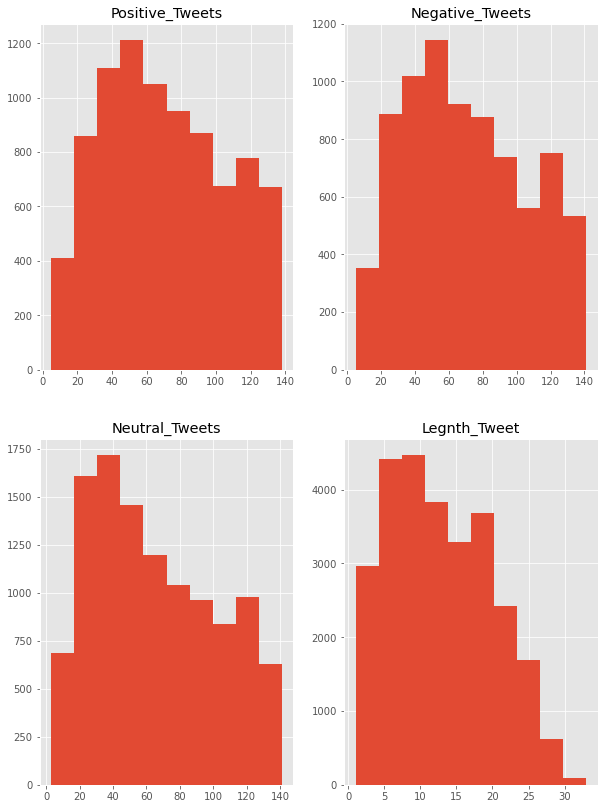

In [27]:
# plotting the number of characters in tweet per sentiment...

# positive tweet lenth
len_positive = train[train['sentiment']=="positive"]['text'].str.len()

# negative tweet length
len_negative = train[train["sentiment"]=="negative"]["text"].str.len()

# neutral tweet length
len_neutral = train[train["sentiment"]=="neutral"]["text"].str.len()

fig,ax = plt.subplots(2,2,figsize=(10,14))

# plotting positive tweet
ax[0,0].hist(len_positive)
ax[0,0].set_title("Positive_Tweets")

# plotting negative tweet
ax[0,1].hist(len_negative)
ax[0,1].set_title("Negative_Tweets")

# plotting positive tweet
ax[1,0].hist(len_neutral)
ax[1,0].set_title("Neutral_Tweets")

# plotting the overall length of tweets...
ax[1,1].hist(train["length"])
ax[1,1].set_title("Legnth_Tweet");

In [28]:
# now it's time to clean text, so let's make a function for it...
def clean_text(text):
    
    # convert text into lower
    text = str(text).lower()
    
    #     remove urls
    text = re.sub(r"https:\S+"," ",text)
    
    #     remove punctuation
    text = re.sub(r"[^\w\s]","",text)
    
    #     remove mentions
    text = re.sub(r'@\w+', " ", text)
    
    #     remove hashtags
    text = re.sub("#\w+"," ", text)
    
    #     remove digits
    text = re.sub(r"\d+"," ", text)
    
    #     remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
        
    return text 


In [29]:
# apply the function to train df
train["clean_text"] = train["text"].apply(lambda x : clean_text(x))

train.sample(10)

,textID,text,sentiment,length,clean_text
13106,4631068d01,Why do none of my thoughts make sense when I`m...,negative,11,why do none of my thoughts make sense when im ...
208,1b13ed8b4b,im thinking that im going to have fun tonight....,positive,14,im thinking that im going to have fun tonighta...
20528,9551138d41,I feel like dressing up for the heck of it.& p...,positive,15,i feel like dressing up for the heck of it put...
11529,f8394d23bf,I feel like crying! One of my diamond earrings...,negative,26,i feel like crying one of my diamond earrings ...
25587,a3a1e21a62,No one`s coming in,neutral,4,no ones coming in
12132,514174445d,Goodnight Beautiful world sweet dreams. olive...,positive,7,goodnight beautiful world sweet dreams olive ...
26367,fed62986b9,"woot, woot! super cool",positive,4,woot woot super cool
23275,2abf604274,Mondays best excited about the week!!,positive,6,mondays best excited about the week
5493,2d882d5270,womp womp woooomp!,positive,3,womp womp woooomp
21778,7d6013021a,pulling articles,neutral,2,pulling articles


In [30]:
# apply it to test data as well
test["clean_text"] = test["text"].apply(lambda x : clean_text(x))

test.sample(10)

,textID,text,sentiment,length,clean_text
1249,c3892f8e77,sadd.. last night in fl.. going back to AR to...,negative,10,sadd last night in fl going back to ar tomorrow
3168,1783b5eb60,Geez I`m hating bein at work till 10 on a day ...,negative,21,geez im hating bein at work till on a day li...
1744,0986073590,"Actually, I think I`ll be more upset if I lost...",neutral,23,actually i think ill be more upset if i lost m...
791,7993d38b85,ha! lemme know what you find (tho I suspect i...,positive,22,ha lemme know what you find tho i suspect it ...
868,4e5d66beb2,I love how when I leave my laptop on my bed it...,positive,17,i love how when i leave my laptop on my bed it...
650,fe626ba958,my baby`s off on his adventure. 14.5 hours in ...,negative,28,my babys off on his adventure hours in the c...
653,5efc764068,Woo - got a fast mobile broadband connection now,neutral,9,woo got a fast mobile broadband connection now
2981,0690c4b873,???! #MandarinMonday,neutral,2,mandarinmonday
984,507a584ae5,"just signed up..so, hello twitter world, here ...",neutral,9,just signed upso hello twitter world here i am
361,37897b1693,Got people don`t let me skip sci pratical beco...,negative,20,got people dont let me skip sci pratical becos...


In [31]:
# setting stopwords
stop=set(stopwords.words('english'))

Text(0.5, 0.98, 'Common words in tweet text')

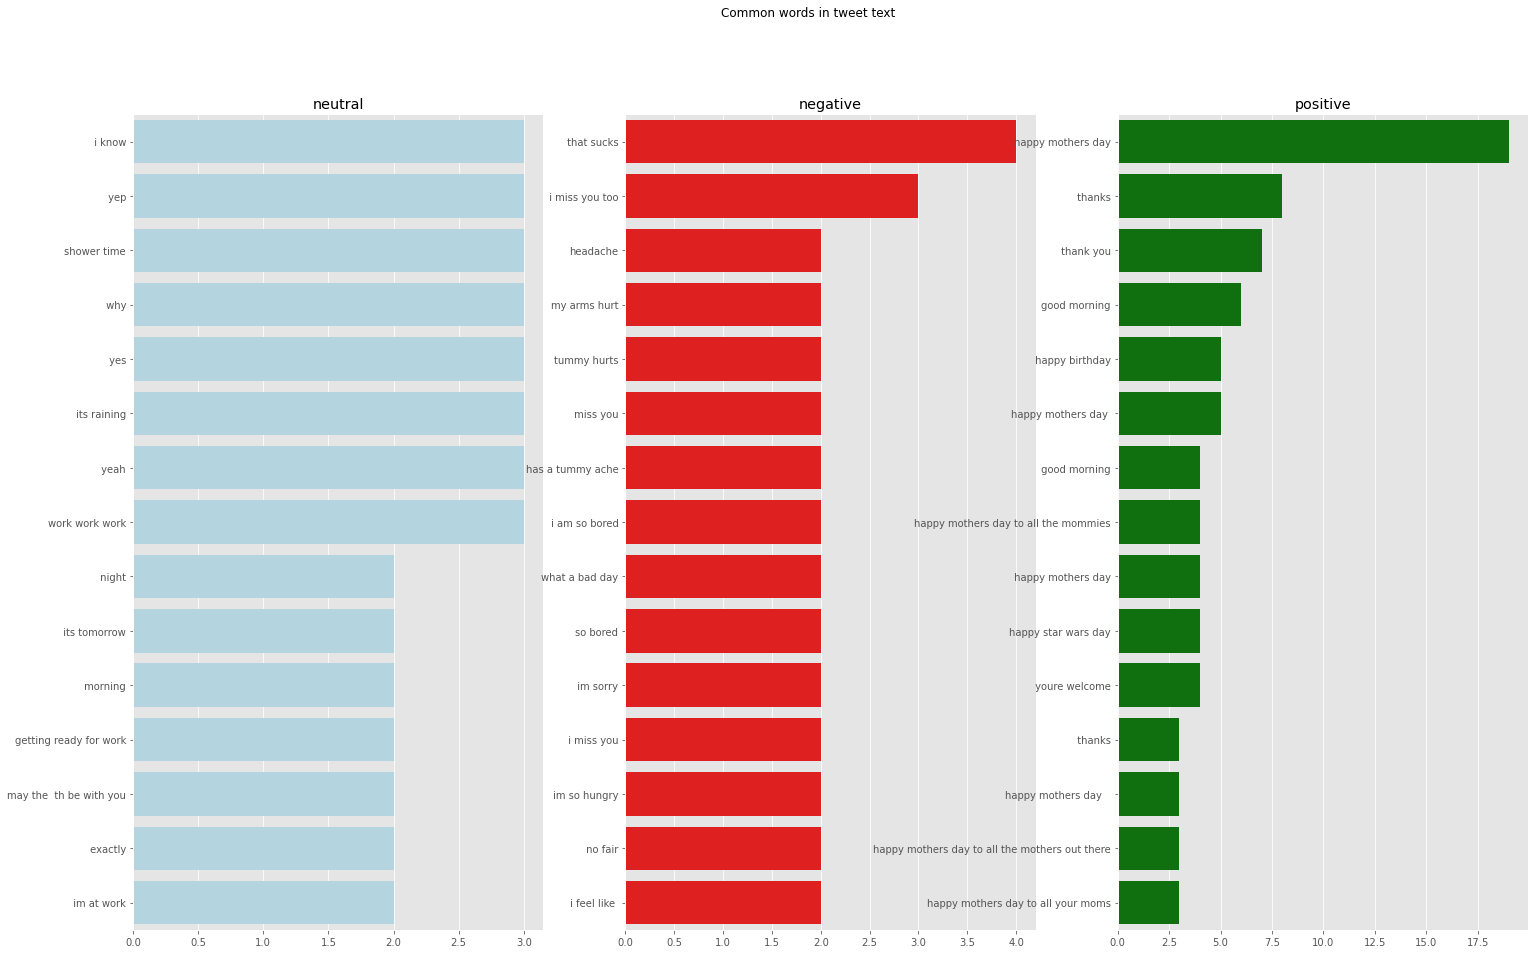

In [32]:
# let's find out the most common words in the text.....
sentiments = train["sentiment"].unique()

# setup the figure
fig,ax = plt.subplots(1,3, figsize=(25,15))
colors = ["lightblue","red","green",]
for i in range(3):
    new = train[train["sentiment"]==sentiments[i]]["clean_text"]
    counter = Counter(new)
    most_common = counter.most_common()
    x = []
    y = []
    
    for word,count in most_common[:15]:
        x.append(word)
        y.append(count)
        
    sns.barplot(x=y,y=x,ax=ax[i], color = colors[i])
    ax[i].set_title(sentiments[i])
fig.suptitle("Common words in tweet text")

In [33]:
# pick the main columns....
train_text = train["clean_text"]
train_labels = train["sentiment"]

test_text = test["clean_text"]
test_labels = test["sentiment"]

In [34]:
# as our label is in text so map it

l = {"neutral" : 0, "positive" : 1,"negative" : 2}

# apply it to the data....

train_labels = train_labels.map(l)
test_labels = test_labels.map(l)

In [35]:
train_text

0                        id have responded if i were going
1               sooo sad i will miss you here in san diego
2                                   my boss is bullying me
3                            what interview leave me alone
4         sons of  why couldnt they put them on the rel...
                               ...                        
27476     wish we could come see u on denver  husband l...
27477     ive wondered about rake to  the client has ma...
27478     yay good for both of you enjoy the break  you...
27479                                but it was worth it  
27480       all this flirting going on  the atg smiles ...
Name: clean_text, Length: 27480, dtype: object

# Tokenization : 
    As we clean our text let's split the data and convert each split into integer through tokenization because our deep learning models works only with the numbers....



In [36]:
# find the average length of sentence...
round(np.mean(train["length"]))

13

In [37]:
# setup the vocabulary length...
max_token = 15000
max_len = 15


token = TextVectorization(max_tokens = max_token,
                         standardize = "lower_and_strip_punctuation",
                         output_mode = "int",
                         output_sequence_length = max_len,
                         split = "whitespace")

# adapt to text
token.adapt(train_text)

Metal device set to: Apple M1


2022-10-16 21:11:44.681930: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-16 21:11:44.682012: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-10-16 21:11:44.710248: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-16 21:11:44.746052: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [38]:
# get some text information....
vocab = token.get_vocabulary()
print(f"Total words in the Vocabulary : {len(vocab)}")
print(f"Top five words in the Vocabulary : {vocab[:5]}")
print(f"Bottom five words in the Vocabulary : {vocab[-5:]}")

Total words in the Vocabulary : 15000
Top five words in the Vocabulary : ['', '[UNK]', 'i', 'to', 'the']
Bottom five words in the Vocabulary : ['rightards', 'rigby', 'rig', 'rieger', 'ridin']


In [39]:
# let's tokenize some sentence....
random_index = np.random.randint(0,len(train_text))
random_sentence = train_text[random_index]

print(f"Original Text : {random_sentence}\n")
print(f"Tokenize Sentence : {token([random_sentence])}")

Original Text : check out this funny movie  httptinyurlcomd qwar

Tokenize Sentence : [[ 279   33   30  359  204 2135    1    0    0    0    0    0    0    0
     0]]


# Embedding
   
  A word embedding is a class of approaches for representing words and documents using a dense vector representation. Word embeddings give us a way to use an efficient, dense representation in which similar words have a similar encoding. Importantly, you do not have to specify this encoding by hand. An embedding is a dense vector of floating point values (the length of the vector is a parameter you specify). Instead of specifying the values for the embedding manually, they are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer). It is common to see word embeddings that are 8-dimensional (for small datasets), up to 1024-dimensions when working with large datasets. A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn

In [40]:
embedd = Embedding(input_dim = max_token,
                  output_dim = 256,
                   input_length = max_len,
                   embeddings_initializer = "uniform",
                  )

In [41]:
# let's tokenize and embedd some sentence....
random_index = np.random.randint(0,len(train_text))
random_sentence = train_text[random_index]

print(f"Original Text : {random_sentence}\n")
print(f"Tokenize Sentence : {token([random_sentence])}\n")
print(f"Tokenize Sentence : {embedd(token([random_sentence]))}")

Original Text : poor ds is in bed with   fever  he wont be able to walk in relay for life tonight  feel so bad for him hes so sad

Tokenize Sentence : [[ 313 2670   10   11  141   22 1175  111  165   24  464    3  713   11
  3471]]

Tokenize Sentence : [[[-0.03479004  0.03959937  0.01954031 ...  0.04770727 -0.00404854
   -0.00715316]
  [ 0.0448926  -0.02105613  0.00854826 ... -0.03886175  0.03701044
   -0.04289728]
  [-0.04844604 -0.02325727  0.01449922 ...  0.02120982  0.01202836
   -0.02886401]
  ...
  [ 0.00717982 -0.02242143 -0.02843162 ...  0.02930192 -0.03782576
   -0.02822474]
  [ 0.04578367  0.00078801  0.02961894 ... -0.03379005 -0.00052049
   -0.00951076]
  [ 0.04729087 -0.03736253 -0.04621473 ...  0.03138942  0.00755279
    0.03812883]]]


In [42]:
# let's make a function to evaluate our model performance....
def calculate_results(y_true,y_pred):
    """
    This function will evaluate our model performace by measuring certain metrics....
    Accuracy : it tells us that how accurately our model predict the label
    Precision : this is the ability of classifier not to label a negative label as positive.
    Recall : this is the ability of classifier to find all positive labels.
    Fscore : this is the average of preicision and recall.
    """
    accuracy = accuracy_score(y_true,y_pred)
    precision_score,recall_score,f_score,_ = precision_recall_fscore_support(y_true,y_pred,average="weighted")
    
    results = {
        "Accuracy" : accuracy ,
        "Precision" : precision_score,
        "Recall" : recall_score,
        "F_Score" : f_score
    }
    return results

# Modelling : 
     
     We'll build a series of model and pick the one that performs better.
    ~Naive Model
    ~Dense Model
    ~LSTM Model
    ~GRU Model

In [43]:
# Model_0 : Naive Model

In [44]:
# let's build our first sklearn naive model...
model_0 = Pipeline([
    ('tfidf',TfidfVectorizer()),
    ("naive",MultinomialNB())
])

# fitting model to data....
model_0.fit(train_text,train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('naive', MultinomialNB())])

In [45]:
# calculate model results....
model_0_results = calculate_results(test_labels,model_0.predict(test_text))
model_0_results

{'Accuracy': 0.620826259196378,
 'Precision': 0.6920038667463424,
 'Recall': 0.620826259196378,
 'F_Score': 0.6084458841291476}

In [46]:
train_labels = to_categorical(train_labels, 3)
test_labels = to_categorical(test_labels,3)


# Model 2 : Simple Dense Model

In [47]:
# let's build our first dense model.....

# set up the random seed....
tf.random.set_seed(42)

# define the inputs....
inputs = layers.Input(shape=(),dtype="string")

# pass inputs to tokenization layer....
x = token(inputs)

# pass the token to embeddings....
x = embedd(x)

# hidden layers...
x = layers.Dense(64,activation="relu")(x)

# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)
# adding the globalaverage layer...
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_1 = tf.keras.Model(inputs,output,name="Dense_Model")

# compiling the model...
model_1.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [48]:
# model summary.....
model_1.summary()

Model: "Dense_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 dense (Dense)               (None, 15, 64)            16448     
                                                                 
 dense_1 (Dense)             (None, 15, 32)            2080      
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                

In [49]:
# fitting the model to data....
history_1 = model_1.fit(train_text,train_labels,
                       epochs=10,
                       validation_data=(test_text,test_labels),
                        validation_split = int(len(test_text) * 0.25),
                        callbacks = [tf.keras.callbacks.ModelCheckpoint("Dense_1.tf",
                                                                               save_best_only=True)])

Epoch 1/10
  1/859 [..............................] - ETA: 6:39 - loss: 1.0968 - accuracy: 0.3750

2022-10-16 21:11:46.018781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - ETA: 0s - loss: 0.8476 - accuracy: 0.6159

2022-10-16 21:12:03.008438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: Dense_1.tf/assets
859/859 [==============================] - 19s 22ms/step - loss: 0.8476 - accuracy: 0.6159 - val_loss: 0.7522 - val_accuracy: 0.6868
Epoch 2/10
859/859 [==============================] - 18s 21ms/step - loss: 0.7024 - accuracy: 0.7143 - val_loss: 0.7370 - val_accuracy: 0.6856
Epoch 3/10
859/859 [==============================] - 18s 22ms/step - loss: 0.6460 - accuracy: 0.7463 - val_loss: 0.7356 - val_accuracy: 0.6930
Epoch 4/10
859/859 [==============================] - 18s 21ms/step - loss: 0.6043 - accuracy: 0.7693 - val_loss: 0.7533 - val_accuracy: 0.6899
Epoch 5/10
859/859 [==============================] - 18s 21ms/step - loss: 0.5693 - accuracy: 0.7827 - val_loss: 0.7801 - val_accuracy: 0.6839
Epoch 6/10
859/859 [==============================] - 18s 20ms/step - loss: 0.5444 - accuracy: 0.7961 - val_loss: 0.7966 - val_accuracy: 0.6771
Epoch 7/10
859/859 [==============================] - 18s 20ms/step - loss: 0.5232 - accuracy:

In [50]:
os.listdir("Dense_1.tf")

['keras_metadata.pb', 'variables', 'saved_model.pb', 'assets']

In [51]:
# let's load the best model...
model_2 = tf.keras.models.load_model("Dense_1.tf")

2022-10-16 21:14:45.228606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:14:45.233674: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [52]:
# make predictions and calculate the results...
model_2_results = calculate_results(test_labels,tf.squeeze(tf.round(model_2.predict(test_text))))
model_2_results

 13/111 [==>...........................] - ETA: 0s

2022-10-16 21:14:45.341667: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 1s 4ms/step


{'Accuracy': 0.6550650820599887,
 'Precision': 0.7319607437801137,
 'Recall': 0.6550650820599887,
 'F_Score': 0.6884914562374292}

In [53]:
# let's make a function that will plot the model performance......
def plot_model_performance(history):
    
    loss = history.history["loss"]
    
    val_loss = history.history["val_loss"]
    
    acc = history.history["accuracy"]
    
    val_acc = history.history["val_accuracy"]
    
    epochs = range(len(loss))
    
    
#     plottint the model accuracy vs validation accuracy
    plt.plot(epochs,acc,label="Training Accuracy",marker = "*",linestyle = "dotted")
    plt.plot(epochs,val_acc,label="Validation Accuracy",marker = "P", linestyle = "dashed")
    plt.title("Training vs Validation Accuracy")
    plt.xlabel("Epochs")
    plt.legend(title="Accuracy")
    
    
#     plotting the training vs validation loss
    plt.figure()
    plt.plot(epochs,loss,label="Training Loss",marker="1", linestyle = "dotted")
    plt.plot(epochs,val_loss,label="Validation Loss",marker = "2", linestyle = "dashed")
    plt.title("Training vs Validation Loss")
    plt.xlabel("Epochs")
    plt.legend(title="Loss")
    plt.show()

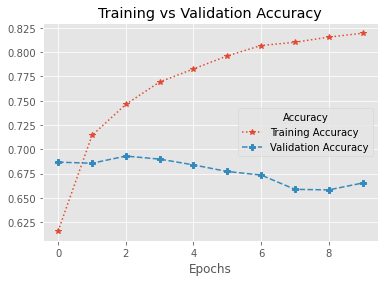

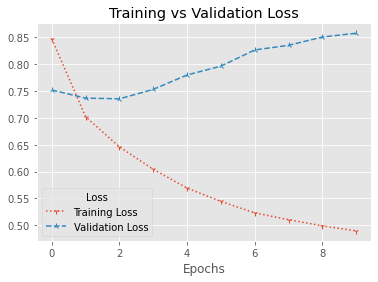

In [54]:
# plot the model performance...
plot_model_performance(history_1)

# Model 3 : LSTM

In [55]:
# let's build the 3rd Model LSTM (Long-Short-Term-Memory)

# set the random seed
tf.random.set_seed(42)

# define the input layer.....
inputs = layers.Input(shape=(),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# hidden layer.....
x = layers.Dense(64,activation="relu")(x)
# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)
# adding the lstm layer
x = layers.LSTM(64,return_sequences=True)(x)

# adding the drop-out layer...
x = layers.Dropout(0.1)(x)

# LSTM layer
x = layers.LSTM(32,)(x)

# output layer....
output = layers.Dense(3,activation="softmax")(x)

# model building....
model_3 = tf.keras.Model(inputs,output,name="LSTM_Model")

# compiling the model...
model_3.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [56]:
# model summary....
model_3.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 dense_3 (Dense)             (None, 15, 64)            16448     
                                                                 
 dense_4 (Dense)             (None, 15, 32)            2080      
                                                                 
 lstm (LSTM)                 (None, 15, 64)            24832     
                                                        

In [57]:
# fitting the model to data....
history_3 = model_3.fit(train_text, train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.25),
                        callbacks = [tf.keras.callbacks.ModelCheckpoint("LSTM.tf",
                                                                               save_best_only=True)])

Epoch 1/10


2022-10-16 21:14:47.661614: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:14:47.918417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:14:47.998728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:14:48.065833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/859 [..............................] - ETA: 28:55 - loss: 1.0973 - accuracy: 0.4688

2022-10-16 21:14:48.187572: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - ETA: 0s - loss: 0.5658 - accuracy: 0.7773

2022-10-16 21:15:16.883493: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:15:16.984778: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:15:17.031886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: LSTM.tf/assets


INFO:tensorflow:Assets written to: LSTM.tf/assets


859/859 [==============================] - 40s 44ms/step - loss: 0.5658 - accuracy: 0.7773 - val_loss: 0.7975 - val_accuracy: 0.6619
Epoch 2/10
859/859 [==============================] - 31s 36ms/step - loss: 0.4847 - accuracy: 0.8148 - val_loss: 0.8044 - val_accuracy: 0.6636
Epoch 3/10
859/859 [==============================] - 29s 34ms/step - loss: 0.4534 - accuracy: 0.8301 - val_loss: 0.8451 - val_accuracy: 0.6599
Epoch 4/10
859/859 [==============================] - 29s 34ms/step - loss: 0.4328 - accuracy: 0.8356 - val_loss: 0.8666 - val_accuracy: 0.6621
Epoch 5/10
859/859 [==============================] - 29s 34ms/step - loss: 0.4197 - accuracy: 0.8441 - val_loss: 0.8618 - val_accuracy: 0.6607
Epoch 6/10
859/859 [==============================] - 29s 34ms/step - loss: 0.4116 - accuracy: 0.8474 - val_loss: 0.8309 - val_accuracy: 0.6686
Epoch 7/10
859/859 [==============================] - 30s 35ms/step - loss: 0.4021 - accuracy: 0.8487 - val_loss: 0.9011 - val_accuracy: 0.6633
Epo

In [58]:
# make prediction and calculate results....
model_3_results = calculate_results(test_labels, tf.squeeze(tf.round(model_3.predict(test_text))))
model_3_results

2022-10-16 21:19:53.761613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:19:53.860046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:19:53.908939: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 2s 10ms/step


{'Accuracy': 0.620826259196378,
 'Precision': 0.6798673323766884,
 'Recall': 0.620826259196378,
 'F_Score': 0.6471967657114281}

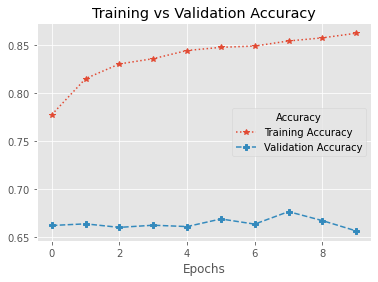

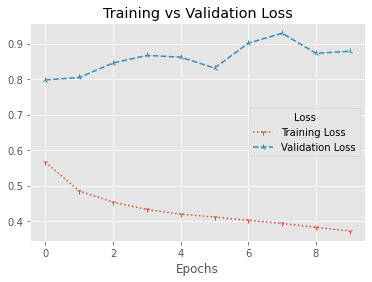

In [59]:
# plot model performance...
plot_model_performance(history_3)

# Model 4 : GRU

In [60]:
# let's build the Model GRU(Gated Recurrent Units)

# set the random seed
tf.random.set_seed(42)

# define the input layer.....
inputs = layers.Input(shape=(),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# hidden layer.....
x = layers.Dense(64,activation="relu")(x)

# adding drop-out layer....
x = layers.Dropout(0.1)(x)

# adding the 2nd layers....
x = layers.Dense(32,activation="relu")(x)

# adding the lstm layer
x = layers.GRU(64,return_sequences=True)(x)

# adding the drop-out layer...
x = layers.Dropout(0.1)(x)

# LSTM layer
x = layers.GRU(32,)(x)

# output layer....
output = layers.Dense(3,activation="sigmoid")(x)

# model building....
model_4 = tf.keras.Model(inputs,output,name="LSTM_Model")

# compiling the model...
model_4.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [61]:
# model summary...
model_4.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 dense_6 (Dense)             (None, 15, 64)            16448     
                                                                 
 dropout_1 (Dropout)         (None, 15, 64)            0         
                                                                 
 dense_7 (Dense)             (None, 15, 32)            2080      
                                                        

In [62]:
# fitting the model to data....
history_4 = model_4.fit(train_text, train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.30))

Epoch 1/10


2022-10-16 21:19:56.815291: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:19:57.077642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:19:57.143906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:19:57.230720: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/859 [..............................] - ETA: 27:28 - loss: 1.0889 - accuracy: 0.2812

2022-10-16 21:19:57.336908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - ETA: 0s - loss: 0.6485 - accuracy: 0.7386

2022-10-16 21:20:28.983825: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:20:29.080228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:20:29.125296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - 35s 39ms/step - loss: 0.6485 - accuracy: 0.7386 - val_loss: 0.7848 - val_accuracy: 0.6576
Epoch 2/10
859/859 [==============================] - 31s 36ms/step - loss: 0.5679 - accuracy: 0.7777 - val_loss: 0.8185 - val_accuracy: 0.6539
Epoch 3/10
859/859 [==============================] - 36s 41ms/step - loss: 0.6099 - accuracy: 0.7541 - val_loss: 0.9154 - val_accuracy: 0.6013
Epoch 4/10
859/859 [==============================] - 40s 46ms/step - loss: 0.6662 - accuracy: 0.7243 - val_loss: 0.9025 - val_accuracy: 0.6171
Epoch 5/10
859/859 [==============================] - 34s 39ms/step - loss: 0.6328 - accuracy: 0.7397 - val_loss: 0.8858 - val_accuracy: 0.6183
Epoch 6/10
859/859 [==============================] - 34s 39ms/step - loss: 0.5918 - accuracy: 0.7612 - val_loss: 0.8617 - val_accuracy: 0.6350
Epoch 7/10
859/859 [==============================] - 32s 38ms/step - loss: 0.5619 - accuracy: 0.7794 - val_loss: 0.9014 - val_accuracy: 0.6350
Epo

In [63]:
# make prediction and calculate results....
model_4_results = calculate_results(test_labels, tf.squeeze(tf.round(model_4.predict(test_text))))
model_4_results

2022-10-16 21:25:30.004073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:25:30.104444: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:25:30.158455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 1s 9ms/step


{'Accuracy': 0.41850594227504245,
 'Precision': 0.55403450159156,
 'Recall': 0.7526881720430108,
 'F_Score': 0.6357711040047936}

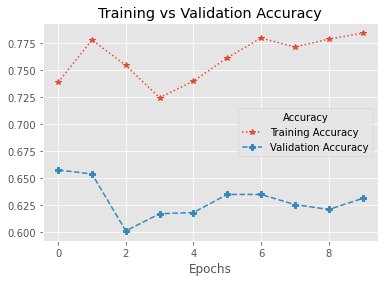

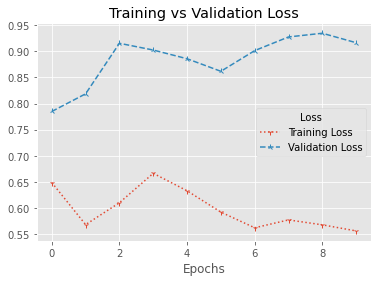

In [64]:
# plot model performance....
plot_model_performance(history_4)

# Model 5 : BiDirectional 

In [65]:
# let's build the BiDirectional Model....

# set the random seed
tf.random.set_seed(42)

# define the input layer.....
inputs = layers.Input(shape=(),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# adding the Bidirectional layer
x = layers.Bidirectional(layers.LSTM(64,return_sequences=True))(x)

# Bidirectional layer
x = layers.Bidirectional(layers.LSTM(32,))(x)

# output layer....
output = layers.Dense(3,activation="sigmoid")(x)

# model building....
model_5 = tf.keras.Model(inputs,output,name="LSTM_Model")

# compiling the model...
model_5.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [66]:
# model summary....
model_5.summary()

Model: "LSTM_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 128)          164352    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               41216     
 nal)                                                            
                                                        

In [67]:
# fitting model to data...
history_5 = model_5.fit(train_text, train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.30))

Epoch 1/10


2022-10-16 21:25:34.670731: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:25:35.122383: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:25:35.132588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:25:35.229943: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:25:35.239985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:25:35.388834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:25:35.405243: I tensorflow/core/grappler/optimizers/cust

859/859 [==============================] - ETA: 0s - loss: 0.5015 - accuracy: 0.8074

2022-10-16 21:26:16.567126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:26:16.699511: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:26:16.706794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:26:16.798336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:26:16.805756: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - 47s 51ms/step - loss: 0.5015 - accuracy: 0.8074 - val_loss: 0.8594 - val_accuracy: 0.6678
Epoch 2/10
859/859 [==============================] - 41s 48ms/step - loss: 0.4260 - accuracy: 0.8430 - val_loss: 0.8605 - val_accuracy: 0.6604
Epoch 3/10
859/859 [==============================] - 43s 49ms/step - loss: 0.3925 - accuracy: 0.8555 - val_loss: 0.8989 - val_accuracy: 0.6695
Epoch 4/10
859/859 [==============================] - 42s 49ms/step - loss: 0.3645 - accuracy: 0.8669 - val_loss: 0.8874 - val_accuracy: 0.6712
Epoch 5/10
859/859 [==============================] - 41s 48ms/step - loss: 0.3350 - accuracy: 0.8779 - val_loss: 0.9218 - val_accuracy: 0.6754
Epoch 6/10
859/859 [==============================] - 40s 47ms/step - loss: 0.3040 - accuracy: 0.8883 - val_loss: 0.9869 - val_accuracy: 0.6695
Epoch 7/10
859/859 [==============================] - 41s 47ms/step - loss: 0.2703 - accuracy: 0.9021 - val_loss: 1.0640 - val_accuracy: 0.6689
Epo

In [68]:
# make predictions and calculate results....
model_5_results = calculate_results(test_labels,tf.squeeze(tf.round(model_5.predict(test_text))))
model_5_results

2022-10-16 21:32:28.650945: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:32:28.780058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:32:28.787193: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  3/111 [..............................] - ETA: 3s  

2022-10-16 21:32:28.874581: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-10-16 21:32:28.882028: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 2s 15ms/step


{'Accuracy': 0.5384833050367855,
 'Precision': 0.6003779223370576,
 'Recall': 0.732597623089983,
 'F_Score': 0.659756510084908}

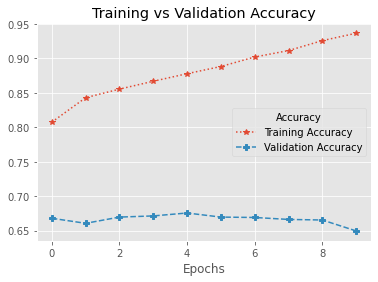

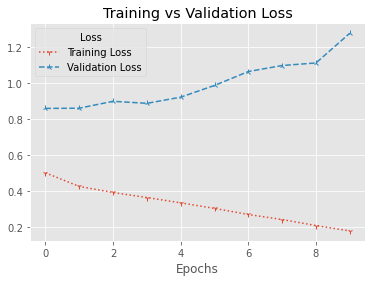

In [69]:
# plot model performance....
plot_model_performance(history_5)

# Model 6 : Conv1D

In [92]:
# as our previous models are overfitting to data....
# let's build another model Conv1D

# set the random seed
tf.random.set_seed(42)

# define the input layer.....
inputs = layers.Input(shape=(),dtype="string")
# pass the input layer to tokenization....
x = token(inputs)
# pass the token into embedd layer.....
x = embedd(x)

# adding the Conv1D layer...
x = layers.Conv1D(filters = 32, kernel_size = 5, activation = "relu")(x)

# adding the MaxPool1D layer....
x = layers.GlobalMaxPool1D()(x)

# output layer....
output = layers.Dense(3,activation="Softmax")(x)

# model building....
model_6 = tf.keras.Model(inputs,output,name="Conv1D_Model")

# compiling the model...
model_6.compile(loss="categorical_crossentropy",
               optimizer="rmsprop",
               metrics=["accuracy"])

In [93]:
# model summary...
model_6.summary()

Model: "Conv1D_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None,)]                 0         
                                                                 
 text_vectorization (TextVec  (None, 15)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 15, 256)           3840000   
                                                                 
 conv1d_7 (Conv1D)           (None, 11, 32)            40992     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_17 (Dense)            (None, 3)                

In [94]:
# fitting the model to data....
history_6 = model_6.fit(train_text,train_labels,
                       epochs = 10,
                       validation_data = (test_text,test_labels),
                       validation_split = int(len(test_text) * 0.20))

Epoch 1/10


2022-10-16 22:14:48.720644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - ETA: 0s - loss: 0.1495 - accuracy: 0.9598

2022-10-16 22:15:08.462914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


859/859 [==============================] - 21s 24ms/step - loss: 0.1495 - accuracy: 0.9598 - val_loss: 1.2115 - val_accuracy: 0.6457
Epoch 2/10
859/859 [==============================] - 18s 22ms/step - loss: 0.0385 - accuracy: 0.9906 - val_loss: 1.5895 - val_accuracy: 0.6109
Epoch 3/10
859/859 [==============================] - 18s 21ms/step - loss: 0.0247 - accuracy: 0.9937 - val_loss: 1.7862 - val_accuracy: 0.6324
Epoch 4/10
859/859 [==============================] - 18s 21ms/step - loss: 0.0197 - accuracy: 0.9951 - val_loss: 1.9401 - val_accuracy: 0.6350
Epoch 5/10
859/859 [==============================] - 18s 21ms/step - loss: 0.0153 - accuracy: 0.9962 - val_loss: 2.1161 - val_accuracy: 0.6358
Epoch 6/10
859/859 [==============================] - 18s 21ms/step - loss: 0.0148 - accuracy: 0.9963 - val_loss: 2.2305 - val_accuracy: 0.6290
Epoch 7/10
859/859 [==============================] - 18s 21ms/step - loss: 0.0128 - accuracy: 0.9968 - val_loss: 2.4506 - val_accuracy: 0.6251
Epo

In [95]:
# make predictions and calculate results....
model_6_results = calculate_results(test_labels,tf.squeeze(tf.round(model_6.predict(test_text))))
model_6_results

 72/111 [==================>...........] - ETA: 0s

2022-10-16 22:19:24.614545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


111/111 [==============================] - 0s 2ms/step


{'Accuracy': 0.6179966044142614,
 'Precision': 0.6256026322855465,
 'Recall': 0.6179966044142614,
 'F_Score': 0.621050823861122}

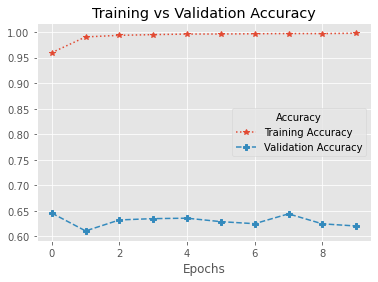

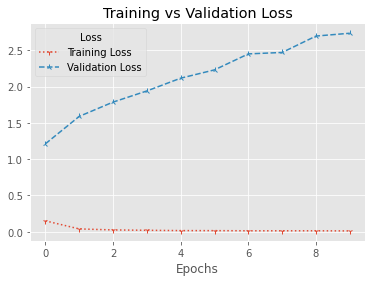

In [96]:
# plot the model performance....
plot_model_performance(history_6)

In [97]:
# Almost all our previous models overfitts the data. So let's try another approach.

# Model 7 : Pretrained Embeddings Transfer Learning

In [ ]:
# we'll build the transfer learning model by using Universal Sentence Encoder Embedding Layer...

# setup the random seed
tf.random.se